# Algorithms in Machine Learning
## Student: Javier CUADRADO ANÍBARRO

The present notebook can be also found in https://github.com/J-Cuadrado/AML_Evaluation

# Prerequisites

Please run the following line of code if the packages are not already installed in your computer, or if you are running this notebook on Google Colab.

In [1]:
# !pip install numpy sklearn torch torchvision matplotlib seaborn tqdm

<div class="alert alert-block alert-warning"><b>Advice:</b> 
    
Due to the amount of time stochastic algorithms can take, as well of the time involved in training a neural network, we suggest completely launching the notebook since the beginning, and gradually explore its content while the code is running.</div>

# Introduction

The aim of this notebook is to present the possible advantages of multidimensional genetic programming for multiclass classification, comparing it to other most common classification methods such as neural networks. The source article for this notebook can be found in the following link:

https://www.sciencedirect.com/science/article/pii/S2210650217309136

The main goal of this article is to present a method for feature selection and construction, which are key components to classification problems in machine learning. Notably, we want to exploit the intrinsic characteristics of genetic programming, which implicitly performs feature selection and construction over the data, while also making fewer _a priori_ assumptions on the data. Let us quote the article to clarify this point in a more rigorous way:

_"A well known learning method that implicitly conducts feature selection and construction is genetic programming (GP), which has been proposed for classification. GP incorporates feature selection and construction by optimizing a population of programs constructed from a set of instructions that operate on the dataset features to produce a model. Compared to traditional ML approaches such as logistic regression and decision tree classification, GP makes fewer a priori assumptions about the data [...]"_

So, in short, we want to exploit the fact that GP algorithms can find hidden interactions among the data, to best summarize it and help the classification.

The interest of this analysis is twofold:

- On the one hand, many industrial applications require multiclass categorization, from fruit classification in supermarkets (https://ieeexplore.ieee.org/abstract/document/8488544) to more sophisticated applications such as image identification (for example, identify from a picture if there is a defect or not in a piece, and what kind of defect it is). It can help automate processes, hence the interest on its research.
- On the other hand, not making assumptions on the data keeps us less constrained to identify hidden interactions we had not accounted for, but which may be representative of certain behaviors. That is the case, for example, of disease detection, which will be treated later on.

We will begin by presenting the data we will use to perform the classifications, and then show the advantages and disadvantages of such an approach. Next, we will compare our simple implementation with the more advanced solutions proposed in the article. Finally, we will explore some potential applications of the algorithm presented in the paper.

# Data generation

We are going to begin by creating the data with which we will work. Our data will consist of a set of $\mathbb{R}^4$ points obtained the following way:

$$\left\{\begin{array}{ll} x_1 \cdot x_3 - x_2 \cdot x_4 & = A \\ x_1 \cdot x_4 + x_2 \cdot x_3 & = B\end{array}\right.$$

Of course, the generation of the poins will be noisy (there is no interest in classifying noiseless points, as each point would exactly fall within the expected category), so the relationship between the values will not exactly add A or B, but something in between. The interest of using such a database comes from the fact that there is a hidden interaction within the different elements, but which is not seen at first glanced: it has to be discovered.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def generate_point(A,B,attenuation=10):
    """
    Definition:
    This function generates a point [x1, x2, x3, x4] so that:
    x1, x2 are randomly drawn from a uniform distribution [-5, 5]
    x3, x4 satisfy the conditions:
        x1*x3 - x2*x4 = A
        x1*x4 + x2*x3 = B
    Finally, a random noise is added to each one of the four values. The noise is drawn
    from a N(0,1) distribution, and divided by the attenuation factor (effectively
    modifying the standard deviation)
    
    Inputs: 
    A, B: real numbers
    attenuation: dividing factor used when adding noise from a N(0,1) distribution
    
    Output:
    [x1, x2, x3, x4]: numpy ndarray of real values 
    """
    
    x1 = np.random.uniform(-5,5) # x1 is arbitrarily chosen to be between -5 and 5
    while x1 == 0:
        x1 = np.random.uniform(-5,5) # We want to avoid x1 being exactly zero
        
    x2 = np.random.uniform(-5,5) # x2 is arbitrarily chosen to be between -5 and 5
    while x2 == 0:
        x2 = np.random.uniform(-5,5) # We want to avoid x2 being exactly zero
        
    x3 = (x1*A+x2*B)/(x1**2+x2**2)
    x4 = (x1*B-x2*A)/(x1**2+x2**2)
    x = [x1, x2, x3, x4] + np.random.randn(1,4)/attenuation
    x = np.float32(x)
    return x[0,:]

<div class="alert alert-block alert-warning"><b>Obs.-</b> It is not the exact values of the points which is important in our analysis, but rather the hidden interactions within them. In fact, x1 and x2 may be generated between any couple of points, and the analysis would still be valid.
   
As for the uniform distribution, it was chosen because it is a the distribution with fewer assumptions on the data values (every value has an equal chance to appear)

In [4]:
def decode(x):
    """
    The sole goal of this function is to verify the correct behavior of the data generation function    
    """
    A = x[0]*x[2]-x[1]*x[3]
    B = x[0]*x[3]+x[1]*x[2]
    return [A, B]

In [5]:
# We generate a test point:
x_test = generate_point(5,5)
print(f"Test point: {x_test}")

Test point: [ 1.870448  -1.8477961  0.0259345  2.8714142]


In [6]:
# We verify that the decoded point is similar to (5,5)
print(f"Decoded point: {decode(x_test)}")

Decoded point: [5.354297, 5.3229094]


<div class="alert alert-block alert-success"><b>We see that the decoded values are reasonable, considered they were extracted from a distribution $N(0,\frac{1}{\sqrt{10}})$.</b>

Once the functions to generate the data have been defined, we proceed to create three shuffled datasets: training (400 points, 100 points per cluster), validation ( 200 points) and test (100 points). We will generate four clusters in each of the datasets: one with points centered around (0,0), another one of points generated around (0,5), a third one of points generated around (5,0), and a final one of points centered around (5,5).

In [7]:
from sklearn.utils import shuffle

def generate_data(points_per_cat):
    """
    Input:
    points_per_cat: integer, number of points in each cluster of the dataset
   
    Output:
    X: dataset
    y: labels
    """
    X = np.zeros((4*points_per_cat,4))
    y = np.zeros((4*points_per_cat,1)).astype(np.int)

    for i in range(points_per_cat):
        X[i,:] = generate_point(0,0)
        y[i,:] = 0
    
    for i in range(points_per_cat, 2*points_per_cat):
        X[i,:] = generate_point(0,5)
        y[i,:] = 1

    for i in range(2*points_per_cat, 3*points_per_cat):    
        X[i,:] = generate_point(5,0)
        y[i,:] = 2

    for i in range(3*points_per_cat, 4*points_per_cat):
        X[i,:] = generate_point(5,5)
        y[i,:] = 3
    
    X, y = shuffle(X, y)
    
    return X, y

# Training set
X, y = generate_data(100)
# Validation set
Xval, yval = generate_data(50)
# Test set
Xtest, ytest = generate_data(25)

Let us take a closer look on some of the data (fist ten points of the suffled training dataset)

In [8]:
for i in range(10):
    print(f"Point #{i}: Values {X[i,:]}, Label {y[i][0]}")

Point #0: Values [-4.01459217  1.20766306  0.25465682 -1.10398626], Label 1
Point #1: Values [ 1.67548501 -1.956622   -0.17733936  2.79524541], Label 3
Point #2: Values [-4.88422537  2.68242311 -0.89403576 -0.28136489], Label 2
Point #3: Values [-4.67319298  0.00672231  0.16059482 -0.13046813], Label 0
Point #4: Values [ 4.32726002 -4.92912102  0.46727061  0.62421197], Label 2
Point #5: Values [ 0.7031337  -2.31549692 -1.91972518  0.45892543], Label 1
Point #6: Values [-1.90000975 -1.46927059 -1.11274612 -1.73482406], Label 1
Point #7: Values [ 4.40846539  2.37218714 -0.04464548 -0.12409797], Label 0
Point #8: Values [-1.45973837 -3.00666332 -1.88053572  0.74519253], Label 3
Point #9: Values [-4.97558165 -4.79323292 -0.02925619 -0.06021468], Label 0


<div class="alert alert-block alert-danger"> <b>Obs.-</b> It is clear that no conclusions can be extracted at first glance from the dataset as far as the predicted labels: a performing algorithm is needed to classify these data.</div>

However, we can plot the decoded data to see that it should be in theory easily classifiable in four distinct clusters.

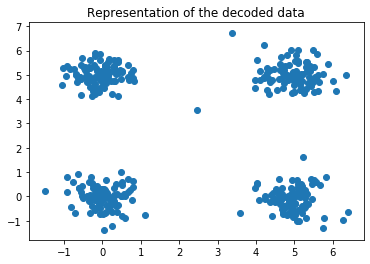

In [9]:
X_ab = np.zeros([400, 2])
for i in range(400):
    X_ab[i,:] = decode(X[i,:])


plt.scatter(X_ab[:,0], X_ab[:,1])
plt.title('Representation of the decoded data')
plt.show()

<div class="alert alert-block alert-success"><b>Four clusters can be identified at first glance after the space transformation!</b> The goal is therefore to be able to obtain such a transformation on the data.

## Data to tensor

Our first impulse is to run the data through a neural network to see if we can classify it. To build the neural networks, we will be using Pytorch. In order to work with Pytorch, we need to convert our numpy arrays into pytorch tensors.

In [10]:
import torch
import torchvision

In [11]:
def data_to_tensor(X,y):
    """
    Inputs:
    X, y: numpy arrays
    
    Output:
    X_tensor, y_tensor: pytorch tensors containing the same information as the input arrays
    """
    
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).long() # Made type long for the nn to work
    
    return X_tensor, y_tensor

X_tensor, y_tensor = data_to_tensor(X,y)
Xval_tensor, yval_tensor = data_to_tensor(Xval, yval)
Xtest_tensor, ytest_tensor = data_to_tensor(Xtest, ytest)


# Neural network on raw data

## Architecture 

We proceed now to the classification of the generated data with our neural network. We have defined a 3-hidden-layer architecture, each of the hidden layers with 10 neurons and a ReLU activation.

- Since the interactions beween the data are fairly simple, we have decided to limit our neural network to a rather small architecture, in an effort to try to avoid overfitting of the values.
- Several activations were tested during the development of this code, and notable efforts were dedicated towards making the algorithm work with sigmoid functions. However, ReLU activation has proven to be the most performing activation  to meet our goals, so it has been chosen as our activation i the hidden layers.
- Points are classed according to the output neuron which yields the higher value among the possible four categories.

In [12]:
from torch import nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, input_neurons = 4):
        super(SimpleNet, self).__init__()
        self.input_neurons = input_neurons
        self.fc1 = nn.Linear(self.input_neurons, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1, self.input_neurons)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x
    
net = SimpleNet()

The NN architecture for the raw data (four input neurons) is therefore as follows (this plot has been obtained with the tool http://alexlenail.me/NN-SVG/):

<img src="pictures/nn.png" width="900px"></img>

## Training

For the training process of the NN, we will begin by defining the Early Stopping criterion, which will have a patience of 5 epochs. This has been done to further prevent the overfitting of the data.

In [13]:
class EarlyStopping:
    
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: %d / %d' % (self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In addition, a maximum of 50 epochs will be allowed in the training process. As for the optimizer, Adam has been found more performing, so it has been the chosen algorithm (it also allows us to not have to define the optimization hyperparameters).

In [14]:
def validation(net, Xval_tensor, yval_tensor):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            inputs = Xval_tensor[data, :]
            labels = yval_tensor[data, :].resize(20)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

def train(net,X_tensor, y_tensor, X_validation, y_validation, earlystopping=True):
    optimizer = torch.optim.Adam(net.parameters())
    train_history = []
    valid_history = []
    estop = EarlyStopping(patience=5)
    for epoch in range(50):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = X_tensor[data, :]
            labels = y_tensor[data, :].resize(20)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net, X_validation, y_validation)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch+1, train_loss, valid_loss))
        estop.step(valid_loss)
        if earlystopping and estop.early_stop:
            break
    return train_history, valid_history

Next, a function has been created to plot the evolution of the train and validation loss over the training period.

In [15]:
def plot_train_val(train, valid):
    """
    Plotter function to represent the evolution of the train and validation loss over the training period.
    """
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()

Finally, we will use a batch size of 20 both for the training and the validation sets. By using small batches, we make the training process slightly less performing, but we also get a faster algorithm, wich in turn allows more epochs to be processed in the same amount of time. For the criterion, we have chosen the Cross Entropy. Having defined all these functions and parameters, we proceed to the training of the neural network:

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 01: train loss 28.50872, validation loss 14.10582
Epoch 02: train loss 28.05960, validation loss 13.96646
Epoch 03: train loss 27.72366, validation loss 13.87183
Epoch 04: train loss 27.45264, validation loss 13.78411
Epoch 05: train loss 27.21054, validation loss 13.70430
Epoch 06: train loss 26.95607, validation loss 13.61354
Epoch 07: train loss 26.68453, validation loss 13.52030
Epoch 08: train loss 26.34234, validation loss 13.39744
Epoch 09: train loss 26.00974, validation loss 13.25205
Epoch 10: train loss 25.56295, validation loss 13.08057
Epoch 11: train loss 25.12531, validation loss 12.91787
Epoch 12: train loss 24.67374, validation loss 12.73236
Epoch 13: train loss 24.17871, validation loss 12.55637
Epoch 14: train loss 23.55145, validation loss 12.30799
Epoch 15: train loss 22.85808, validation loss 12.06856
Epoch 16: train loss 22.24461, validation loss 11.77163
Epoch 17: train loss 21.44872, validation loss 11.47909
Epoch 18: train loss 20.69233, validation loss 1

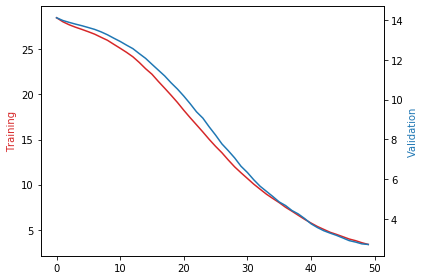

In [16]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet()
train_history, valid_history = train(net, X_tensor, y_tensor, Xval_tensor, yval_tensor)
plot_train_val(train_history, valid_history)

A nice, visual metric of the accuracy of our classifier can be obtained through the confusion matrix on the test data.

Confusion matrix:


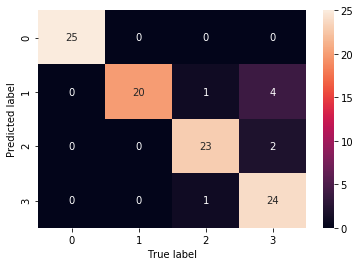

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
outputs = net(Xtest_tensor)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix:")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.xlabel("True label")
plt.ylabel("Predicted label") 
plt.show()

We can see that our NN is reasonably accurate (it is able to correctly classify most of the points, even if the dataset is noisy and does not show the hidden interactions within the data). The discrepancies between the true data and the predicted values come from the noise introduced in data generation (lower noise yields higher accuracies), as well as the low number of epochs. However, a longer training may lead to overfitting, since the neural network may simply end up by learning the points "by heart, and not the noisy distribution.

Nonetheless, this accuracy can be improved, and the following sections will try to present a method to achieve higher accuracies.

# Neural network on transformed data

We proceed now to perform the same analysis on the decoded dataset, that is, on the (A,B) noisy pairs)

In [18]:
X_decoded = torch.zeros([400, 2], dtype=torch.float)
for i in range(400):
    X_decoded[i,:] = torch.FloatTensor(decode(X_tensor[i,:]))
    
Xval_decoded = torch.zeros([200, 2], dtype=torch.float)
for i in range(200):
    Xval_decoded[i,:] = torch.FloatTensor(decode(Xval_tensor[i,:]))
    
Xtest_decoded = torch.zeros([100, 2], dtype=torch.float)
for i in range(100):
    Xtest_decoded[i,:] = torch.FloatTensor(decode(Xtest_tensor[i,:]))

The goal of this section is to demonstrate that, by performing the same classification on the decoded dataset, higher accuracies can in fact be obrained without overfitting of the data.

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 01: train loss 26.66360, validation loss 12.87573
Epoch 02: train loss 24.86824, validation loss 11.97213
Epoch 03: train loss 22.86526, validation loss 10.79784
Epoch 04: train loss 20.43893, validation loss 9.61559
Epoch 05: train loss 18.09062, validation loss 8.46236
Epoch 06: train loss 15.86670, validation loss 7.42335
Epoch 07: train loss 13.91582, validation loss 6.52692
Epoch 08: train loss 12.12829, validation loss 5.62464
Epoch 09: train loss 10.30473, validation loss 4.66660
Epoch 10: train loss 8.29566, validation loss 3.60266
Epoch 11: train loss 6.21074, validation loss 2.68376
Epoch 12: train loss 4.57813, validation loss 1.95660
Epoch 13: train loss 3.32424, validation loss 1.42518
Epoch 14: train loss 2.42955, validation loss 1.05917
Epoch 15: train loss 1.81131, validation loss 0.80500
Epoch 16: train loss 1.37532, validation loss 0.62902
Epoch 17: train loss 1.08226, validation loss 0.49488
Epoch 18: train loss 0.85313, validation loss 0.40235
Epoch 19: train 

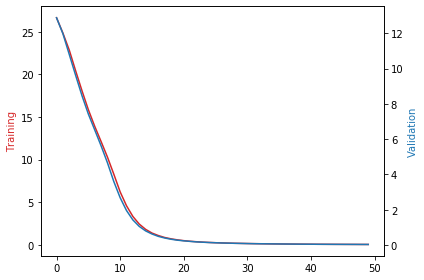

In [19]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet(input_neurons = 2)
train_history, valid_history = train(net, X_decoded, y_tensor, Xval_decoded, yval_tensor)
plot_train_val(train_history, valid_history)

Confusion matrix:


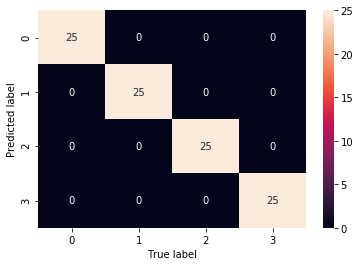

In [20]:
y_pred = []
outputs = net(Xtest_decoded)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix:")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.xlabel("True label")
plt.ylabel("Predicted label") 
plt.show()

As expected, the decoded dataset perfoms better than the raw one, being able to mitigate the noise influence on the classification. However, we have cheated on this analysis, since we knew the decoding algorithm prior to making the data classification. In real life, the data decoding may not be known, so we should be able to find a way to learn it.

<div class="alert alert-block alert-info"><b>The following sections will explore how to improve the classification accuracy when the interactons between the data are unknown.</b>

# Genetic Programming

We now seek to classify the data using an stochastic method. We will follow the philosophy presented on the paper, using stack-based programs, but with slight modifications to get a faster and easier to understand code. The algorithm developped in the paper is called M4GP, and will later be presented in more depth.

<div class="alert alert-block alert-warning"><b>Even if we will try our best to explain the M4GP algorithm presented in the paper, the reader is strongly encouraged to consult it for further information.</b>

First of all, we will present the stack-based programs described in the paper. Basically, these programs consist of a vector of possible opperations to be performed on the data, in order to transform it into another state. In order to best explain these programs, we will take the following one as an example:

program = $[0, 2, *, 1, 3, *, -, 0, 3, *, 1, 2, *, +]$

This program performs the following tasks, in order, adding the result of each operation to an output array:

- 0 -> Access x[0] and store it in the output array -> output = [x0]
- 2 -> Access x[2] and store it in the output array -> output = [x0, x2]
- \* -> Pop the last two components of the output array, multiply them, and add the result to the output array -> output = [x0\*x2]
- 1 -> Access x[1] and store it in the output array -> output = [x0\*x2, x1]
- 3 -> Access x[3] and store it in the output array -> output = [x0\*x2, x1, x3]
- \* -> Pop the last two components of the output array, multiply them, and add the result to the output array -> output = [x0\*x2, x1\*x3]
- \- -> Pop the last two components of the output array, substract them, and add the result to the output array -> output = [x0\*x2 - x1\*x3]
- ...

So, in the end, we will obtain an output vector which, in this case, will consist of **[x0\*x2 - x1\*x3, x0\*x3 + x1\*x2]**. How fitting, it is exactly the operations we followed to decode de data!

We proceed then to create a code able to generate such a sequence/program.

In [21]:
import random

def program_generator(data_len):
    """
    Input:
    data_len: number of components of the data (in each line)
    
    Output:
    program: a stack-based program (list) to be performed on the data
    """
    program_len = random.randint(2,20)
    
    program = []
    
    
    values = [i for i in range(data_len)]
    
    program.append(random.choice(values))
    program.append(random.choice(values))

    values.append('+')
    values.append('-')
    values.append('*')
    values.append('/')
    
    for i in range(2,program_len):
        program.append(random.choice(values))
    
    return program

# sample data
x_test = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
data_len = x_test.shape[1]
# obtention of a random program
program_test = program_generator(data_len)
print(program_test)   

[2, 2, '+', '+', 1, 1, 0, '*', 1, 0, 3]


<div class="alert alert-block alert-danger"><b>Not all of the programs can be run.</b> Some of them will, for example, consist of operations on the third and four elements of the list, which will lead to an error because there won't be enough arguments on the output stack to pop. This problem will be solved in the genetic optimization section.

Next, we define a function able of running the different programs on the data, which returns an array with the transformed dataset

In [22]:
def program_reader(program, x):
    """
    Input:
    program: list of operations to perform on the data
    x: array of raw data
    
    Output:
    outmat: it can either be an array with the transformed data, or an string "Error" is the program cannot be run
    """
    output = []
    for ele in program:
        if type(ele) == int:
            output.append(x[:,ele])
        else:
            try:
                b = output.pop()
                a = output.pop()
                if ele == '+':
                    output.append(a+b)
                elif ele == '-':
                    output.append(a-b)
                elif ele == '*':
                    output.append(a*b)
                elif ele == '/' and b != 0:
                    output.append(a/b)
                else:
                    raise
            except:
                output = 'Error'
                break
           
    if output == 'Error':
        outmat = 'Error'
    else:
        newdim = len(output)
    
        outmat = np.zeros((x.shape[0],newdim))
        for ele in range(newdim):
            outmat[:,ele] = output[ele]
        
    return outmat 

out_test = program_reader(program_test, x_test)
print(out_test)

Error


We will now proceed to optimize the programs generated, trying to achieve the best possible classification. After having defined the parameters of the optimization, we follow the next steps:

- We remove the "worst" individuals of the population, so we only keep the top 250 ones
- We generate individuals until we obtain a complete population
- We verify which of the programs are erroneous, and remove them from the population
- We class each program according to its score with a Nearest Centroid classifier
- We check if the maximum number of stall generations has been reached

<div class="alert alert-block alert-warning"><b>Obs.-</b> The score is evaluated on the predictions done on the training set. To further improve performances, we could have analyzed the score of the validation  dataset, but that would mean performing the transformation also on it, which would increase the number of operations to perform.

In [23]:
from sklearn.neighbors import NearestCentroid
from tqdm import tqdm

max_generations = 2000
population_size = 500
population = []
y = y.reshape((400,))

stall = 0
max_stall = 500
last_best = []

for gen in tqdm(range(max_generations)):
    
    # In each generation, we only retain the best 250 individuals
    while len(population) > 0.5*population_size:
        population.pop()
    
    # We complete the population up to 500 individuals
    for ind in range(len(population), population_size):
        population.append(program_generator(X.shape[1]))
    
    # We generate the output of each program, and identify wheteher or not it is an error
    output = []
    errors = []
    for i in range(population_size):
        output.append(program_reader(population[i], X))
        if type(output[-1]) == str:
            errors.append(i)

    errors.reverse()        
    
    # We remove the erroneous programs from the population
    for err in errors:
        output.pop(err)
        population.pop(err)
        
    # We use a Nearest-Centroid clasification to rank the programs    
    score = []
    for i in range(len(output)):
        clf = NearestCentroid()
        clf.fit(output[i], y)
        score.append(clf.score(output[i],y))
    
    # We sort the programs according to their score
    keys = sorted(range(len(score)), key=lambda k: score[k])
    keys.reverse()
    
    population_ordered = []
    for k in keys:
        population_ordered.append(population[k])
    population = population_ordered
    
    # We check if we have achieved the maximum number of stall generations
    if population[0] == last_best:
        stall += 1 
        if stall == max_stall:
            print("Reached max. number of stall generations")
            break
    else:
        last_best = population[0]
        stall = 0
    
print(f"Best program found: {population[0]}")

 57%|████████████████████████████████████████████▍                                 | 1138/2000 [03:25<02:35,  5.55it/s]

Reached max. number of stall generations
Best program found: [2, 1, '*', 3, 1, '*', 3, 0, 2, '*']


We have not obtained the program we would have expected. Nevertheless, this transformation may be good enough, since there may even be hidden interactions between the data we had not accounted for. In fact, if we check this classifier with the test data, we obtain the following confusion matrix:

Confusion matrix:


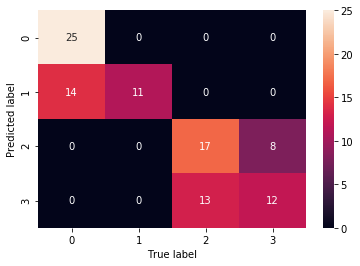

In [24]:
program_best = population[0]

X_trans = program_reader(program_best, X)
clf = NearestCentroid()
clf.fit(X_trans, y)

Xtest_trans = program_reader(program_best, Xtest)
ytest = ytest.reshape((100,))
ytest_pred = clf.predict(Xtest_trans)

print("Confusion matrix:")
cf_matrix = confusion_matrix(ytest, ytest_pred)
sns.heatmap(cf_matrix, annot=True)
plt.xlabel("True label")
plt.ylabel("Predicted label") 
plt.show()

Seeing these results, we may think that this classifier is worse than our neural network, but we must bear in mind that the performin NN was developped on the converted data. In order to compare the efficacity of the GA, we will run the transformed data over a NN, and see its performance.

In [25]:
X_decoded2 = program_reader(program_best, X)
Xval_decoded2 = program_reader(program_best, Xval)
Xtest_decoded2 = program_reader(program_best, Xtest)

In [26]:
X_decoded2_tensor, _ = data_to_tensor(X_decoded2,y)
Xval_decoded2_tensor, _ = data_to_tensor(Xval_decoded2, yval)
Xtest_decoded2_tensor, _ = data_to_tensor(Xtest_decoded2, ytest)

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 01: train loss 27.78580, validation loss 13.81247
Epoch 02: train loss 27.07004, validation loss 13.51969
Epoch 03: train loss 26.41884, validation loss 13.21478
Epoch 04: train loss 25.72776, validation loss 12.85136
Epoch 05: train loss 24.87558, validation loss 12.35136
Epoch 06: train loss 23.66039, validation loss 11.71736
Epoch 07: train loss 22.28761, validation loss 10.95417
Epoch 08: train loss 20.70725, validation loss 10.12953
Epoch 09: train loss 18.95603, validation loss 9.25211
Epoch 10: train loss 17.31388, validation loss 8.50802
Epoch 11: train loss 15.97946, validation loss 7.90609
Epoch 12: train loss 14.84170, validation loss 7.39432
Epoch 13: train loss 13.78202, validation loss 7.04180
Epoch 14: train loss 13.04452, validation loss 6.67295
Epoch 15: train loss 12.31184, validation loss 6.41099
Epoch 16: train loss 11.75023, validation loss 6.15465
Epoch 17: train loss 11.20987, validation loss 5.88159
Epoch 18: train loss 10.72181, validation loss 5.66696
Ep

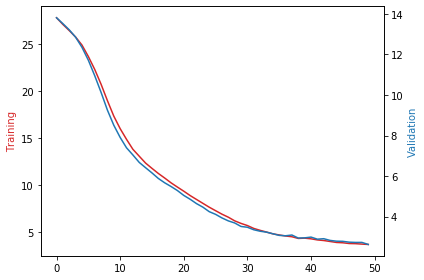

In [27]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet(input_neurons = X_decoded2.shape[1])
train_history, valid_history = train(net, X_decoded2_tensor, y_tensor, Xval_decoded2_tensor, yval_tensor)
plot_train_val(train_history, valid_history)

Confusion matrix:


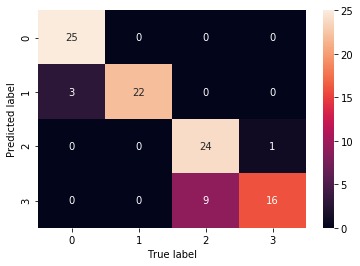

In [28]:
y_pred = []
outputs = net(Xtest_decoded2_tensor)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix:")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.xlabel("True label")
plt.ylabel("Predicted label") 
plt.show()

We can easily see that we have improved the accuracy over the first NN classification. It may be true that the time spent to obtain these results can be higher than when simply using a neural network to classify the data, but is is also true that, after having transoformed the data, it becomes much easier to be learnt, hence reducing the risk the NN has to simply "memorize" the training data and not really learn the proper classification.

# Differences with the source article

While the philosophy behind our code and the M4GP algorithm presented in the article are mostly the same, several simplifications have been done for the sake of clarity. In this section, we will explain these differences, which are in part responsible for the enhanced performances of the M4GP algorithm.

We will begin by succintly presenting the M4GP algorithm:

- It uses a stack-based program representation, exactly as the code we have developped
- It incorporates a multi-objective parent selection and survival technique
- It introduces an archiving strategy that maintains a set of optimal trade-off solutions based on complexity and accuracy

The idea of the algorithm is to find a set of transformations (programs) $\Phi(x): \mathbb{R}^p \to \mathbb{R}^d$ that projects the data into an space where they are more easily classified by a nearest centroid method. However, the M4GP algorithm uses the Mahalanobis distance instead of the Euclidean distance when assigning the points to the different centrois, since it has found that it is more appropriate for the classification problem.

<div class="alert alert-block alert-danger"><b>Obs.-</b> The Mahalanobis distance is defined as:
    
$D_M(x',X_k) = \sqrt{(x'-\mu_k)\Sigma_k^{-1}(x'-\mu_k)^T}$
    
where $\mu_k$ is the centroid of $X_k$ and $\Sigma_k \in \mathbb{R}^{p*p}$ is the within-class covariance matrix. We therefore see that, for each classification, one matrix has to be inverted, which can sometimes be computationally expensive.

Another difference between our code and the M4GP algorithm is that it works with subtrees and leaves, wich can cosist of either a component of the data (ex.- [2]) or two components and an operation (ex.- [2 2 \*]). This approach guarantees that the programs are always valid, but avoid certain interactions, such as the product of sums.

So far, we have not greatly differed from the source material. However, the M4GP algorithm performs the selection and variation process differently. These differences will be presented in the following lines.

## Selection

In order to select the programs to keep, we have simply retained the ones with the highest score when comparing the methods. However, the M4GP algorithm has been tested with three different selection methods:

- **Tournament selection**: This method consists on selecting a set of individuals (it can be any number, but M4GP uses two) and keeping the one which is bet suited as a parent for the next generations. This way, genetic diversity is preserved, since a tournament between several of the worst-scoring parents will guarantee that one of them is kept as a parent for the next generation. In a way, we have followed a similar approach, but our tournament has been performed with the whole population, and the top 250 individuals have been retained. However, since we have not implemented mutations or crossover of individuals (since our easy problem did not require it), it was not crucial to keep genetic diversity, and we thus decided to not follow this approach. This method is explained in depth in the book "A fiel guide to genetic programming" by Riccardo Poli (http://www0.cs.ucl.ac.uk/staff/W.Langdon/ftp/papers/poli08_fieldguide.pdf)

- **Lexicase selection**: This approach consists on selecting the individuas which best perform on certainly test cases. The method runs several test cases on the population, and then randomly orders these cases. Next, it elliminates every individual which has not the best performance in the first test case (the test is often binary: either an individual satisgyes the test case or it does not). It continues with the remaining individuals analyzing the second test case, and so on until only one individual remains, which will be kept as a parent for the next generation. The process is done until the desired number of parents is achieved. This method can therefore often keep "specialist" individuals: for example, if the first test case is only satisfied by one individual, it will automatically be kept as a parent for the next generation, even if it is the only test case the individual is able to succeed in. Lexicase selection is further explained in the article "Solving Uncompromising Problems WithLexicase Selection" by Thomas Helmuth and Lee Spector (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6920034)

- **Age-fitness Pareto selection**: This algorithm assigns each individual an age, corresponding to the number of generations since its first ancestor appeared. After each generation, a random individual is added, and then a number of offspring equal to the total population size is generated. The algorithm then keeps the individuals based on a combination of the "strength" of each one of them (whether it dominates or is dominated by a lot of individuals) and density estimate (wether the individual is in a highly-populated region or a rather empty one). More information on this method can be found on chapter eight of the book "Genetic Programming Theory and Practice VIII", by Michael Schmidt and Hod Lipson (https://link.springer.com/chapter/10.1007%2F978-1-4419-7747-2_8)

A final difference between the M4GP algorithm and our simple example, is that M4GP keeps an archive of the best solbutions obtained during the optimization process (similar to a Pareto front, with a complexity-accuracy tradeoff). To choose the final solution, they are all evaluated over a validation set, and then only the one with the highest score is kept as the optimal solution.

## Variation

As far as variation is concerned, the M4GP algorithm, like almost every other genetic algorithm, incorporates crossover and mutation with a given likelyhood on random individuals. Since the problem we have analyzed did not require such a diverse genetic pool, these methods have not been implemented, but they could easily be incorporated in the algorithm to further improve its performances.

Since the M4GP program works with leaves and subtrees (as previously explained), these processes are very simple to perform (in our code, they may easily lead to erroneous programs):

- For the mutation, either a sub-tree is replaced with a randomly generated one, either a randomly-generated sub-tree is added to the program, either a root sub-tree is removed (operator plus components affected).
- For the crossover, standard corssover is done either between root (operators) or non-root (component) nodes of two parents

# Possible applications

Among the experimental analysis presented in the paper, perhaps the most interesting and promising one is the application of M4GP to disease prediction fromm genome-wide association studies (https://dl.acm.org/doi/pdf/10.1145/3071178.3071212). The idea is to use the algorithm to identify nonlinear interactions in simulated genome-wide association studies, that is to say, to identify epistatic interactions of genes from noisy datasets.

<div class="alert alert-block alert-info"><b>Obs.-</b> Epistasis is the phenomenon of some genes hiding the effect of other genes: for example, if a person has blond-hair, but has also the baldness gene, the baldness gene will hide their hair color. In other words, it is impossible to know the hair color of a bald person, since the baldness gene hides it.
    
However, that gene is there, and in some cases epistatic genes can lead to illnesses. We therefore need to be able to identify those hidden genes and their interactions in order to best diagnose and treat said diseases.
    
More information on the epistasis phenomenon can be found in https://en.wikipedia.org/wiki/Epistasis

The algorithm has been tested with a series of GAMETES (https://biodatamining.biomedcentral.com/articles/10.1186/1756-0381-5-16) datasets. GAMETES is a software capable of generating noisy datasets with epistatic interactions among the genes, so it is an interesting ressource to use for this problem. The software used to generate these datasets, as well as the User's Guide, can be found in https://sourceforge.net/projects/gametes/files/

After having analysed the results, it was concluded that the M4GP algorithm can compete with other state-of-the-art classification techniques in terms of speed (sometimes being even faster) and accuracy, specially when parallellizing the computations. 

# Limitations of the algorithm

As previously stated above, the fact of hafing to invert a matrix for the calculations of the Mahalanobis distance can make the code slow, since it is an expensive computation.  One possible solution would be to maintain a single model $\Phi$ and evolve a population corresonding to the dimensions of $\Phi$, hence making only a matrix inversion per generation. However, this approach would also limit the exploration of the functions space, so in the end we will have to choose a trade-off exploration vs. speed.

Another improvement, as also shown in our code, would be to pair the M4GP algorithm with other classification techniques. M4GP simply uses a Nearest Centroid classification (using Mahalanobis instead of Euclidean distance) once the optimal transformation has been found. However, other classifications could be done, such as a neural network (as we proposed). Nevertheless, even if we obtained promising results in our simple test example, it is not trivial to find the classifier which best pairs with the GP, so it should be chosen on a case-by-case basis.

# Summary

We have begun this notebook by presenting the generation of a dataset with hidden interactions. We have then tried to classify the data before and after its decoding, showing that a transformation (in this case, dimensionality reduction) can help in the process without risking to overfit the data. Next, we have introduced a stochastic method to try to find the hidden interactions in the data.

Afterwards, we have presented the M4GP algorithm, an algorithm aimed at finding these hidden interactions with stack-based programs. We have shown its differences with our code, as well as its applications and limitations.

We hope you have found this notebook illustrative and interesting (the goal of this code was never to replicate the M4GP algorithm, but rather to illustrate its philosophy and performances via simple examples). We are open to any suggestions to further improve the notebook, and will more than gladly listen to any input given regarding this.